# Risk Modeling with Geometric Brownian Motion

Here is a common approach to modeling risk using geometric Brownian motion accompanied by a Monte Carlo simulation. This model will not include a drift component for simplicity's sake.

Some things to keep in mind:

1. The formula for geometric Brownian motion is given by: $dS_{t} = \mu S_{t}dt + \sigma S_{t}dW_{t}$
2. We are assuming the equity or index is modeled by a random walk, and set drift to 0.
3. Volatility is not constant, nor is it entirely random. Therefore, we need to model it in a way that represents the transitions to and from high and low volatility. In this example, we will use Markov chains.

A Markov chain is a process that depends on the last value in a time series to predict the next value. It forms a matrix of unique states by transitions from one state to another.

Our process is as follows:

1. Calculate volatility. We will be using the Garman-Klass estimator for simplicity.
2. Partition the data into bins to create levels. We will be using k-means clustering for simplicity.
3. Create a transition matrix based on past data.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import t, lognorm
from sklearn.cluster import KMeans

In [13]:
# Read the data from file.
df = pd.read_csv('./../data/clean/aapl-daily-compact.csv', index_col='timestamp')
df.head()

,open,high,low,close,volume
timestamp,,,,,
2020-05-22,315.77,319.23,315.35,318.89,20450754
2020-05-26,323.50,324.24,316.50,316.73,31380454
2020-05-27,316.14,318.71,313.09,318.11,28236274
2020-05-28,316.77,323.44,315.63,318.25,33449103
2020-05-29,319.25,321.15,316.47,317.94,38399532


### Estimate volatility.

Determining volatility from HLOC data does not really capture the capture the frequency where the price occurs the most. To get better volatility measures, capture the daily price distribution.

Garman-Klass is one of the more biased estimators, as it does not take into account jumps. Even GARCH or MCMC would be big improvements, but here we get reasonable enough results for simplicity's sake.

In [14]:
# The Garman-Klass estimator.
v = []
for i in df.index.values:
    temp = df.loc[i]
    hi,lo,o,c = temp.high,temp.low,temp.open,temp.close
    v.append(np.sqrt(.5*np.log(hi/lo)**2-((2*np.log(2)-1)*np.log(c/o)**2)))

df['volatility'] = v
df.head()

,open,high,low,close,volume,volatility
timestamp,,,,,,
2020-05-22,315.77,319.23,315.35,318.89,20450754,0.006118
2020-05-26,323.50,324.24,316.50,316.73,31380454,0.010912
2020-05-27,316.14,318.71,313.09,318.11,28236274,0.011973
2020-05-28,316.77,323.44,315.63,318.25,33449103,0.017039
2020-05-29,319.25,321.15,316.47,317.94,38399532,0.010061


### Partition volatility.

In [15]:
# The k-means clustering with three volatility levels.
km = KMeans(3)
km.fit(df['volatility'].values.reshape(-1, 1))
past_levels = km.labels_
past_levels

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0,
       0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 0, 0,
       2, 2, 2, 2, 0, 0, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2,
       2, 0, 2, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 2, 0, 2, 0, 2, 0, 2, 2, 2, 0, 0], dtype=int32)

### The transition matrix.

In [16]:
# The transition matrix.
tm = np.zeros((3, 3))

for i in range(1, len(past_levels)):
    a, b = past_levels[i-1], past_levels[i]
    tm[a][b] += 1
    
# Get the matrix's probabilities.
t_matrix = (tm/tm.sum(axis=1).reshape(-1,1)).cumsum(axis=1)
t_matrix

array([[0.6097561 , 0.65853659, 1.        ],
       [1.        , 1.        , 1.        ],
       [0.26785714, 0.26785714, 1.        ]])

We have now loaded our data set, estimated the volatility, clustered our data set into three bins, and created our transition matrix.

### The Monte Carlo.

Now to create the Monte Carlo:
1. Create a volatility distribution from past values, binning them according to level.
2. Update the current level with each iteration.
3. Run the model and update level array at each time step.

In [17]:
# Generate a lot of random values to draw the distribution.
v_dist = lognorm.rvs(*lognorm.fit(v), size=50000)
vd_levels = km.predict(v_dist.reshape(-1, 1))

v_dict = dict()

for i in range(3):
    v_dict[str(i)] = v_dist[vd_levels==i]
    
t_steps, n_paths = 20, 1000

# Get initial volatility level based on last volatility level and transition matrix.
levels = np.zeros(n_paths)
r_draw = np.random.uniform(size=n_paths)

for i in range(n_paths):
    temp = r_draw[i]
    for j in range(3):
        if temp <= t_matrix[past_levels[-1]][j]:
            levels[i] = j
            break
        else:
            pass

Now to actually run the Monte Carlo:

In [18]:
# Guess the degrees of freedom.
degrees = t.fit(df.volatility.values)[0]
w_t = t.rvs(degrees, loc=0.0, scale=1.0, size=(t_steps, n_paths))

# Start the Monte Carlo.
for i in range(t_steps):
    sigma, current_levels = np.zeros(n_paths), np.zeros(n_paths)
    for j in range(3):
        idx = np.where(levels==j)[0]
        sigma[idx] = np.random.choice(v_dict[str(j)], size=len(idx))
        current_levels[idx] = j
        
    w_t[i] *= sigma
    levels = current_levels
    
# Get the prices from predicted returns.
returns = np.vstack((np.ones(n_paths), np.exp(w_t)))

s0 = df.close.iloc[-1]
prices = s0 * returns.cumprod(axis=0)
prices

array([[121.1       , 121.1       , 121.1       , ..., 121.1       ,
        121.1       , 121.1       ],
       [119.73913571, 116.0083483 , 120.55437091, ..., 119.91145297,
        119.97660226, 121.61800258],
       [117.97673294, 113.008513  , 113.97164554, ..., 117.55151255,
        109.46125468, 120.55256988],
       ...,
       [ 80.75274976, 115.50216331, 102.00680756, ..., 120.7310647 ,
        108.05169982, 136.25816327],
       [ 80.83974285, 125.59202035, 102.25874036, ..., 120.52734545,
        109.30298868, 136.66839755],
       [ 79.68615605, 120.820852  , 101.70234908, ..., 117.43467836,
        108.65654238, 130.2122867 ]])

We could have used a different distribution over Student T, e.g. Johnson SU or Laplace.

Laplace is fairly close to Student T:
* Laplace has the tallest, sharpest peak and wider hips.
* Student T has a wider peak and shoulders, and has fatter tails.

Student T captures the low values of volatility in the distribution better, some moderate values slightly worse, and the fat tail risk better. Student T will thusly produce more outliers.

You should be choosing the appropriate distribution for your given asset. A customized distribution (i.e. hermite polynomials) may also work here, but they may not be generalizable (it is non-continuous).

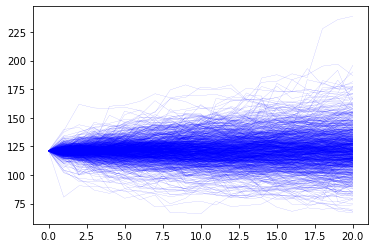

In [19]:
# Plot the prices.
plt.plot(prices, color='b', linewidth=0.1, alpha=0.8)
plt.show()

We can use this to plot to get probabilities of certain prices over some range of time, normally 20 or 30 days.

This is more to backtest specific strikes than to value an option. You would need historical option data, particularly IV, to value contracts.

Say you have five years of data. You can hold out one year to get an initial volatility distribution and then run the model every day for the next four years of data to create a list of possible prices.

You can then pick a probability, which is essentially delta of an option, and get the corresponding price from eahc price list and get a labeled set of successful and unsuccessful trades. You can then use a different model to find patterns that predict those successful trades based on some set of features.

### Points of improvement.

1. Use multithreading to run several Monte Carlos simultaneously.
2. Include a drift component.
3. Run with GARCH fitting at each step to get a rolling forecast.
4. If you have an asset with strong periodicity, then an AR model would definitely outperform a simpler stochastic such as this.

In [20]:
# Get the geometric mean.
g_mean = lambda x: np.exp(np.log(prices[-1]).sum() / len(prices))
g_mean

<function __main__.<lambda>(x)>